<a href="https://colab.research.google.com/github/robinfwrsg/Houses_price_kathmandu/blob/main/houses_kathmandu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
# Installing Folium
!pip install folium
!pip install category_encoders
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import MarkerCluster
import re
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, LabelEncoder
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact, IntSlider
import category_encoders as ce
from sklearn.preprocessing import MinMaxScaler
# Setting plot style for better visuals
plt.style.use('seaborn-v0_8')
sns.set_palette("deep")
%matplotlib inline
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'


In [47]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [48]:
file_path = '/content/drive/MyDrive/nepal_houses.csv'


In [49]:
# Loading the dataset
df = pd.read_csv('/content/drive/MyDrive/nepal_houses.csv')

# Filtering for Kathmandu
df_kathmandu = df[df['City'] == 'Kathmandu'].copy()

# Displaying first 5 rows to understand the data
print("First 5 rows of Kathmandu data:")
print(df_kathmandu.head())

# Displaying dataset info (columns, data types, non-null counts)
print("\nDataset Info:")
print(df_kathmandu.info())

First 5 rows of Kathmandu data:
                                               Title  \
0  Flat System House On Sale At Budhanikantha : H...   
1  21 Aana Beautiful House : House For Sale In Bu...   
2  Beautiful To Floor House : House For Sale In D...   
3  Modern Architecture Bungalow House : House For...   
4  Modern Bungalow House : House For Sale In Golf...   

                                    Address       City      Price  Bedroom  \
0  Budhanikantha, Budhanilkantha, Kathmandu  Kathmandu   90000000        6   
1        Pasikot, Budhanilkantha, Kathmandu  Kathmandu   80000000        5   
2               Dhapasi, Dhapasi, Kathmandu  Kathmandu   70000000        5   
3           baluwatar, Baluwatar, Kathmandu  Kathmandu  130000000        6   
4             Golfutar, Golfutar, Kathmandu  Kathmandu  100000000        6   

   Bathroom  Floors  Parking  Face    Year Views           Area  \
0         3     2.0       10  West  2073.0    17   1-0-0-0 Aana   
1         3     2.0        9

In [50]:
print(df_kathmandu[['Price', 'Bedroom', 'Bathroom', 'Floors', 'Parking',  'Amenities']].describe())

              Price      Bedroom     Bathroom      Floors      Parking
count  1.483000e+03  1483.000000  1483.000000  728.000000  1483.000000
mean   3.568617e+11     3.008092     2.031018    2.929258     1.119353
std    7.357471e+12     4.522541     2.665896    1.094633     2.255878
min    9.000000e+01     0.000000     0.000000    0.000000     0.000000
25%    2.000000e+06     0.000000     0.000000    2.500000     0.000000
50%    1.400000e+07     2.000000     0.000000    3.000000     0.000000
75%    3.250000e+07     5.000000     4.000000    3.000000     2.000000
max    2.160000e+14    95.000000    40.000000   12.000000    31.000000


In [51]:
def convert_area(area_str):
    if isinstance(area_str, str):
        area_str = area_str.strip()
        try:
            if 'Aana' in area_str:
                parts = area_str.replace(' Aana', '').split('-')
                if len(parts) == 4:
                    ropani, aana, paisa, daam = map(float, parts)
                    total_aana = ropani * 16 + aana + paisa / 4 + daam / 16
                else:
                    total_aana = float(parts[0])
                return total_aana * 342.25
            elif 'Ropani' in area_str:
                parts = area_str.replace(' Ropani', '').split('-')
                if len(parts) == 1:
                    return float(parts[0]) * 5476
                elif len(parts) == 4:
                    ropani, aana, paisa, daam = map(float, parts)
                    total_aana = ropani * 16 + aana + paisa / 4 + daam / 16
                    return total_aana * 342.25
            elif 'Sq. Feet' in area_str:
                return float(area_str.replace(' Sq. Feet', ''))
            elif 'Dhur' in area_str:
                return float(area_str.replace(' Dhur', '')) * 182.25
        except:
            return np.nan
    return np.nan

df_kathmandu['Area_sqft'] = df_kathmandu['Area'].apply(convert_area)
df_kathmandu['Build_Area_sqft'] = df_kathmandu['Build Area'].apply(convert_area)

# Converting Road Width to numeric
df_kathmandu['Road_Width_ft'] = df_kathmandu['Road Width'].str.extract(r'(\d+\.?\d*)').astype(float)

# Extracting numbers with error handling
df_kathmandu['Bedroom'] = df_kathmandu['Bedroom'].astype(str).str.extract(r'(\d+)(?:\s*Bedroom)?')[0].astype(float)
df_kathmandu['Bathroom'] = df_kathmandu['Bathroom'].astype(str).str.extract(r'(\d+)(?:\s*Bathroom)?')[0].astype(float)
df_kathmandu['Floors'] = pd.to_numeric(df_kathmandu['Floors'].astype(str).str.extract(r'(\d+)')[0], errors='coerce')
df_kathmandu['Parking'] = df_kathmandu['Parking'].astype(str).str.extract(r'(\d+)(?:\s*Parking)?')[0].astype(float)

# Filling missing values with median or 0 if median is NaN
for col in ['Bedroom', 'Bathroom', 'Parking']:
    median = df_kathmandu[col].median()
    df_kathmandu[col] = df_kathmandu[col].fillna(median if pd.notna(median) else 0)
# Counting amenities safely
df_kathmandu['Amenities_Count'] = df_kathmandu['Amenities'].apply(
    lambda x: len(eval(x)) if isinstance(x, str) and x.startswith('[') and x != '[]' else 0
)

# Dropping rows with missing Price
df_kathmandu = df_kathmandu.dropna(subset=['Price'])


In [52]:
# Displaying summary
print("Summary Statistics after Cleaning:")
print(df_kathmandu[['Price', 'Bedroom', 'Bathroom', 'Floors', 'Parking', 'Area_sqft', 'Build_Area_sqft', 'Road_Width_ft', 'Amenities_Count']].describe())

Summary Statistics after Cleaning:
              Price      Bedroom     Bathroom      Floors      Parking  \
count  1.483000e+03  1483.000000  1483.000000  728.000000  1483.000000   
mean   3.568617e+11     3.008092     2.031018    2.905220     1.119353   
std    7.357471e+12     4.522541     2.665896    1.102991     2.255878   
min    9.000000e+01     0.000000     0.000000    0.000000     0.000000   
25%    2.000000e+06     0.000000     0.000000    2.000000     0.000000   
50%    1.400000e+07     2.000000     0.000000    3.000000     0.000000   
75%    3.250000e+07     5.000000     4.000000    3.000000     2.000000   
max    2.160000e+14    95.000000    40.000000   12.000000    31.000000   

          Area_sqft  Build_Area_sqft  Road_Width_ft  Amenities_Count  
count  1.423000e+03     2.360000e+02    1483.000000      1483.000000  
mean   2.672367e+11     1.468771e+05      14.964262         4.364127  
std    1.008088e+13     1.057007e+06      11.228131         5.836699  
min    0.00000

In [53]:
# Step 1: Cleaning unrealistic prices FIRST
df_kathmandu_clean = df_kathmandu[df_kathmandu['Price'] >= 500000].copy()
print(f"Original data: {len(df_kathmandu)} properties")
print(f"After removing unrealistic prices: {len(df_kathmandu_clean)} properties")
print(f"Removed: {len(df_kathmandu) - len(df_kathmandu_clean)} properties")

# Step 2: cleaning the other columns using the cleaned dataset
for col in ['Bathroom', 'Floors', 'Parking']:  # Leave out Bedroom for custom handling
    non_zero_median = df_kathmandu_clean.loc[df_kathmandu_clean[col] > 0, col].median()
    df_kathmandu_clean[col] = df_kathmandu_clean[col].replace(0, non_zero_median)

# Custom handling for Bedroom
valid_bedroom_values = df_kathmandu_clean.loc[df_kathmandu_clean['Bedroom'] > 0, 'Bedroom']
zero_count = sum(df_kathmandu_clean['Bedroom'] == 0)

if zero_count > 0:  # Only if there are zeros to replace
    replacement_values = np.random.choice(valid_bedroom_values, size=zero_count, replace=True)
    df_kathmandu_clean.loc[df_kathmandu_clean['Bedroom'] == 0, 'Bedroom'] = replacement_values

df_model = df_kathmandu_clean.copy()

# Dropping columns with excessive missing data
df_model = df_model.drop(['Build_Area_sqft', 'Year'], axis=1)

# Handling remaining missing data and outliers
floors_median = df_model['Floors'].median()
df_model['Floors'].fillna(floors_median, inplace=True)

if 'Road Type' in df_model.columns and df_model['Road Type'].dtype == 'object':
    df_model['Road Type'].fillna('Unknown', inplace=True)

df_model.loc[df_model['Parking'] > 10, 'Parking'] = 10

# Capping unrealistic road widths
df_model.loc[df_model['Road_Width_ft'] > 50, 'Road_Width_ft'] = 50

road_width_median = df_model.loc[df_model['Road_Width_ft'] > 0, 'Road_Width_ft'].median()
df_model.loc[df_model['Road_Width_ft'] == 0, 'Road_Width_ft'] = road_width_median

# Removing the extreme high-price outlier
df_model = df_model[~((df_model['Price'] > 100000000) & (df_model['Area_sqft'] < 2000))]

#removing properties with unrealistically low price per sq ft
price_per_sqft = df_model['Price'] / df_model['Area_sqft']
df_model = df_model[price_per_sqft > 500]  # Remove if less than 500 NPR per sq ft

print("Data cleaning completed!")

Original data: 1483 properties
After removing unrealistic prices: 1276 properties
Removed: 207 properties
Data cleaning completed!


<ipython-input-53-ca94721bace8>:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_model['Floors'].fillna(floors_median, inplace=True)
<ipython-input-53-ca94721bace8>:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', 

In [54]:
# Columns to check for outliers (focus on key columns)
cols_to_check = ['Price', 'Bedroom', 'Area_sqft',]

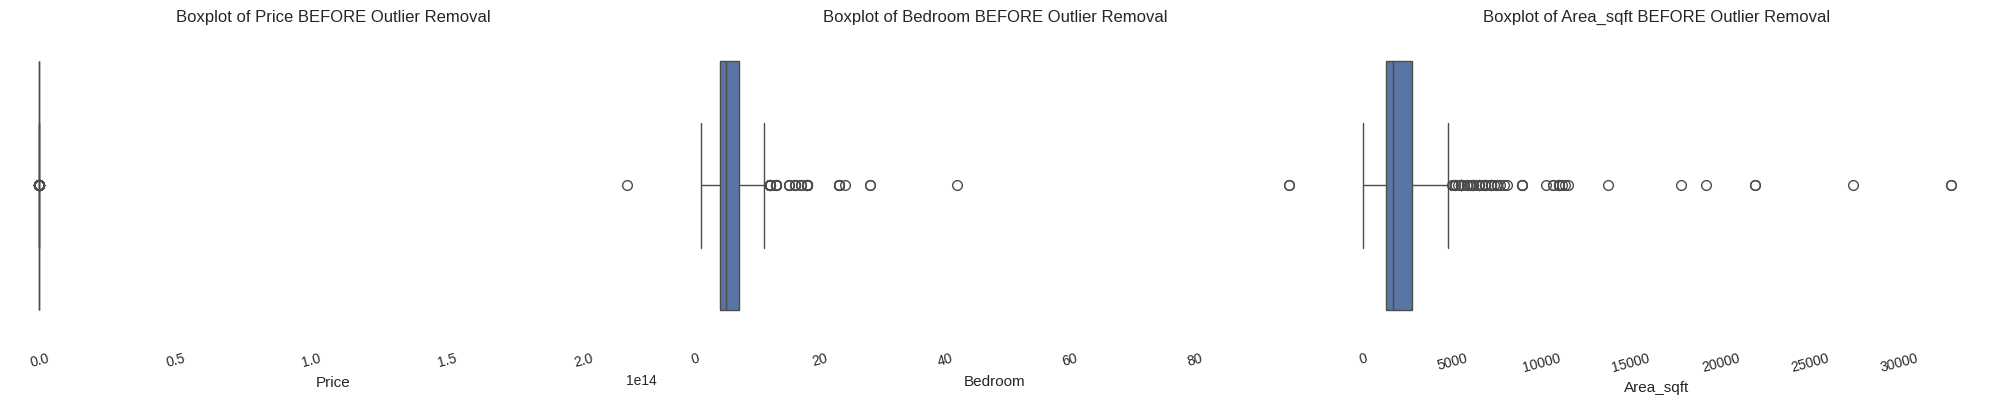

In [55]:
# --- 3. Boxplots BEFORE outlier removal ---
plt.figure(figsize=(20, 15))
for i, col in enumerate(cols_to_check, 1):
    plt.subplot(4, 3, i)
    sns.boxplot(x=df_model[col])
    plt.title(f'Boxplot of {col} BEFORE Outlier Removal')
    plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

In [56]:
def get_outlier_bounds(data, col, factor=3):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    return lower_bound, upper_bound


In [57]:
# --- 4. Removing Outliers ---
bounds = {}
for col in cols_to_check:
    bounds[col] = get_outlier_bounds(df_model, col, factor=5)

filter_condition = True
for col in cols_to_check:
    lower, upper = bounds[col]
    filter_condition = filter_condition & (df_model[col] >= lower) & (df_model[col] <= upper)
df_model = df_model[filter_condition]

print(len(df_model))

1103


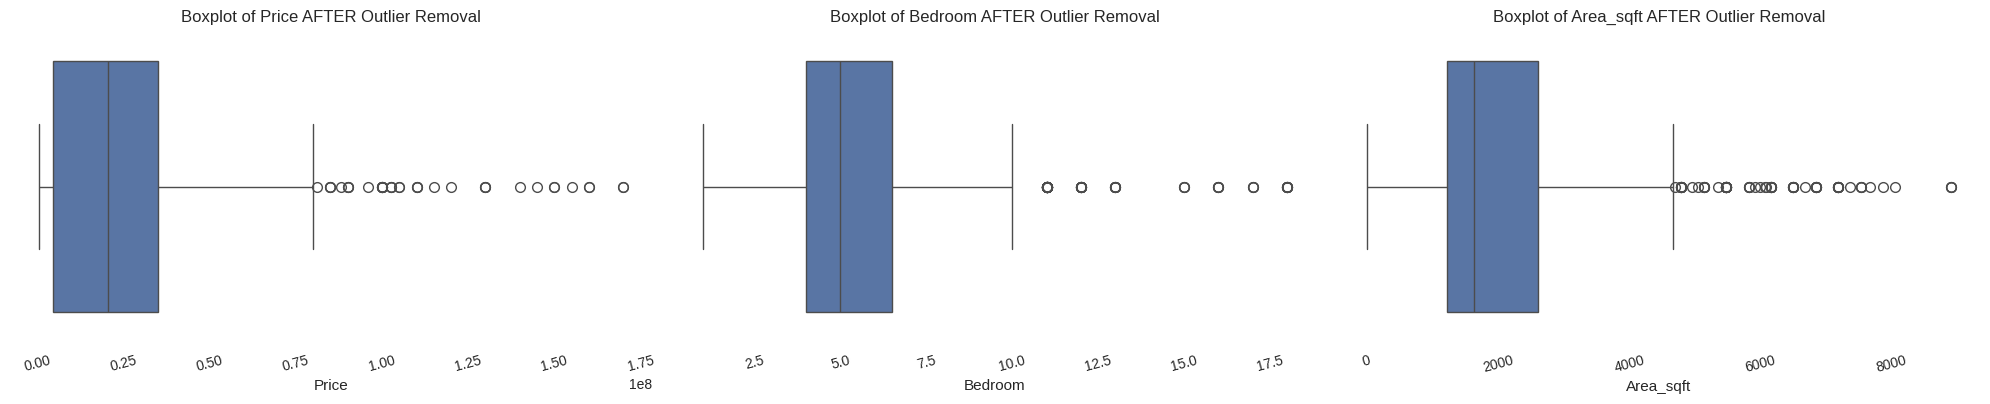

In [58]:

# --- 7. Boxplots AFTER cleaning ---
plt.figure(figsize=(20, 15))
for i, col in enumerate(cols_to_check, 1):
    plt.subplot(4, 3, i)
    sns.boxplot(x=df_model[col])
    plt.title(f'Boxplot of {col} AFTER Outlier Removal')
    plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

In [59]:
# --- 3. Summary after cleaning and outlier removal ---

print("Summary Statistics after Cleaning and Outlier Removal:")
print(df_model[cols_to_check + ['Road_Width_ft', 'Amenities_Count']].describe())

Summary Statistics after Cleaning and Outlier Removal:
              Price      Bedroom    Area_sqft  Road_Width_ft  Amenities_Count
count  1.103000e+03  1103.000000  1103.000000    1103.000000      1103.000000
mean   2.553583e+07     5.781505  2137.800800      15.477788         4.590209
std    2.568577e+07     2.526510  1474.192250       5.111924         6.027973
min    5.000000e+05     1.000000     3.100000       3.000000         0.000000
25%    4.450000e+06     4.000000  1219.265625      13.000000         0.000000
50%    2.060000e+07     5.000000  1642.800000      14.000000         2.000000
75%    3.500000e+07     6.500000  2609.656250      16.000000         7.000000
max    1.700000e+08    18.000000  8898.500000      50.000000        30.000000


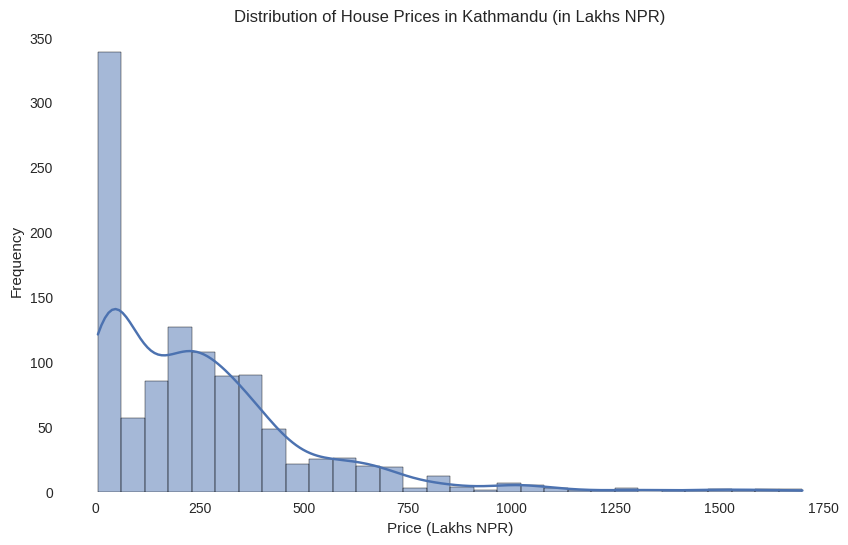

In [60]:
# Plotting the cleaned distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_model['Price'] / 100000, kde=True, bins=30)
plt.title('Distribution of House Prices in Kathmandu (in Lakhs NPR)')
plt.xlabel('Price (Lakhs NPR)')
plt.ylabel('Frequency')
plt.show()

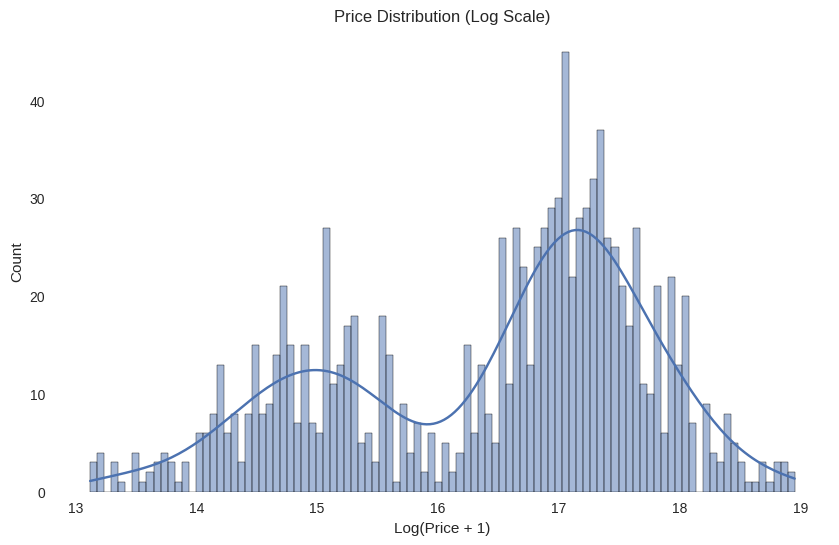

In [61]:

# Log scale distribution for better spread
plt.figure(figsize=(10, 6))
sns.histplot(np.log1p(df_model['Price']), bins=100, kde=True)
plt.title('Price Distribution (Log Scale)')
plt.xlabel('Log(Price + 1)')
plt.ylabel('Count')
plt.show()

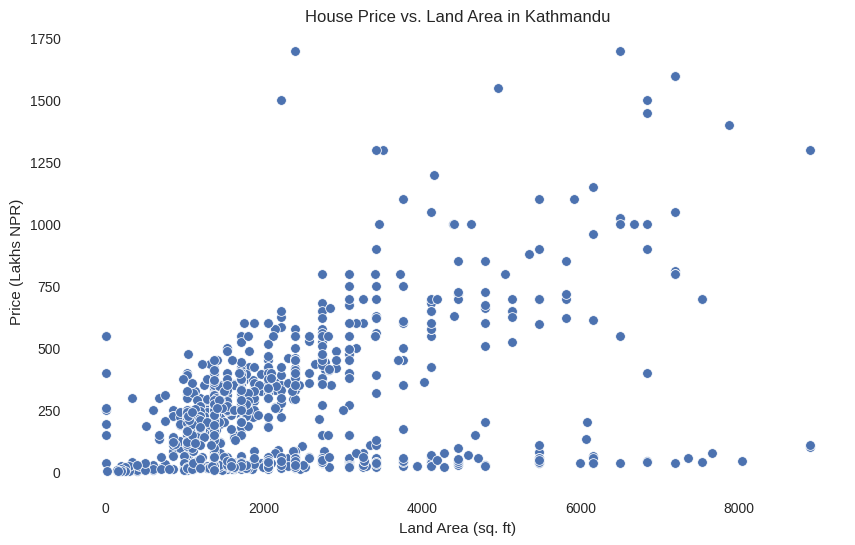

In [62]:
# Plot 2: Price vs. Land Area (in Lakhs)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Area_sqft', y='Price', data=df_model.assign(Price=df_model['Price']/100000))
plt.title('House Price vs. Land Area in Kathmandu')
plt.xlabel('Land Area (sq. ft)')
plt.ylabel('Price (Lakhs NPR)')
plt.show()

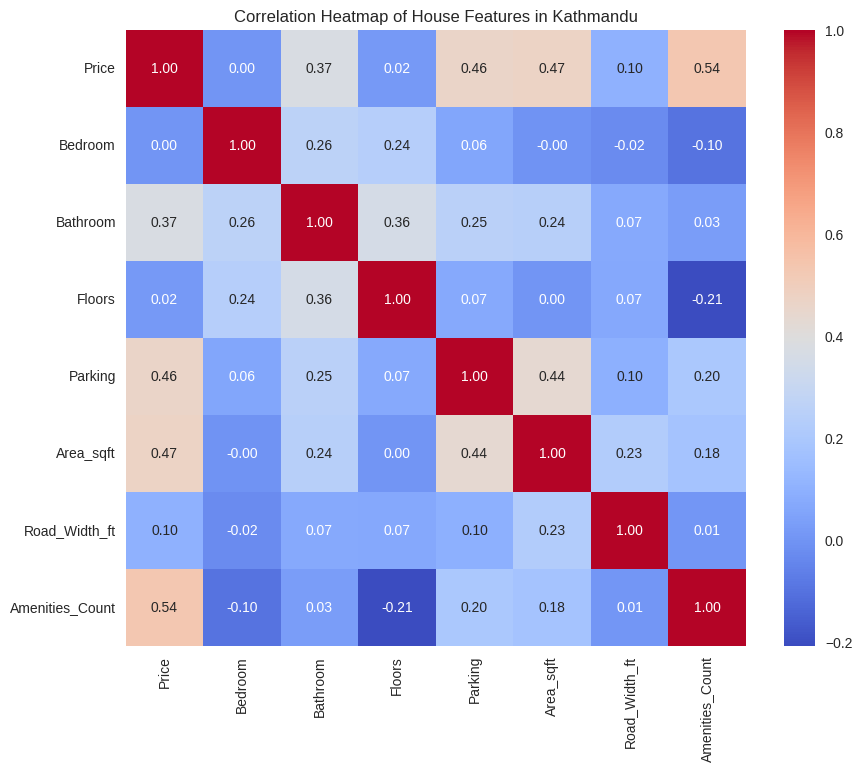

In [63]:
# Plot 3: Correlation Heatmap
numeric_cols = ['Price', 'Bedroom', 'Bathroom', 'Floors', 'Parking', 'Area_sqft', 'Road_Width_ft', 'Amenities_Count']
corr_matrix = df_model[numeric_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of House Features in Kathmandu')
plt.show()

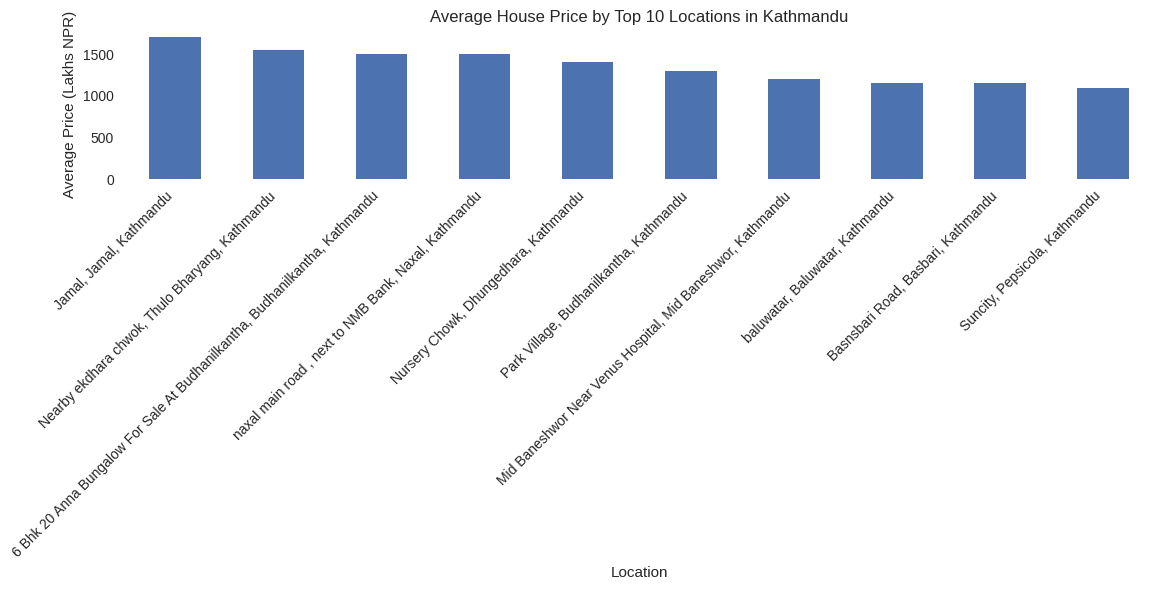

In [64]:
# Plot 4: Average Price by Location (Top 10) - in Lakhs
top_areas = df_model.groupby('Address')['Price'].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(12, 6))

# Converting to lakhs
top_areas_lakhs = top_areas / 100000

top_areas_lakhs.plot(kind='bar')
plt.title('Average House Price by Top 10 Locations in Kathmandu')
plt.xlabel('Location')
plt.ylabel('Average Price (Lakhs NPR)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [65]:
# Defining approximate coordinates for Kathmandu neighborhoods (based on common areas)
location_coords = {
    'Budhanilkantha': [27.776, 85.359],
    'Baluwatar': [27.727, 85.334],
    'Dhapasi': [27.744, 85.337],
    'Golfutar': [27.752, 85.356],
    'Banasthali': [27.707, 85.294],
    'Sukedhara': [27.737, 85.339],
    'Sitapaila': [27.708, 85.279],
    'Narephate': [27.708, 85.349],
    'Thankot': [27.681, 85.243],
    'Kalanki': [27.694, 85.281],
    'Kavresthali': [27.748, 85.298],
    'Pepsicola': [27.693, 85.374],
    'Kapan': [27.737, 85.362],
    'Mandikatar': [27.736, 85.344],
    'Hattigauda': [27.752, 85.344],
    'Maligaon': [27.716, 85.336],
    'Tokha': [27.760, 85.325],
    'Swayambhu': [27.715, 85.291],
    'Tarkeshwor': [27.743, 85.301],
    'Mhepi': [27.717, 85.298],
    'Pasikot': [27.766, 85.356],
    'Maharajgunj': [27.736, 85.333],
    'Raniban': [27.727, 85.287],
    'Manamaiju': [27.737, 85.311],
    'Goldhunga': [27.744, 85.294],
    'Syuchatar': [27.701, 85.271],
    'Thulo Bharyang': [27.707, 85.277],
    'Baniyatar': [27.731, 85.312]
}

# Creating a Folium map centered on Kathmandu
kathmandu_map = folium.Map(location=[27.7172, 85.3240], zoom_start=12)
marker_cluster = MarkerCluster().add_to(kathmandu_map)

# Adding markers for each house
for idx, row in df_model.iterrows():
    address = row['Address'].split(',')[0].strip()
    if address in location_coords:
        price_lakhs = row['Price'] / 100000
        folium.Marker(
            location=location_coords[address],
            popup=f"{address}: {price_lakhs:.2f} Lakhs NPR",
            icon=folium.Icon(color='blue' if price_lakhs < 500 else 'red')
        ).add_to(marker_cluster)

# Saving the map
kathmandu_map.save('kathmandu_price._map.html')
print("Interactive map saved as 'kathmandu_price._map.html'. Download and open in a browser.")

Interactive map saved as 'kathmandu_price._map.html'. Download and open in a browser.


In [66]:
# Handling categorical variables (if any)
df_model_encoded = df_model.copy()

# Extract neighborhood from address
def extract_neighborhood(address):
    parts = address.split(', ')
    if len(parts) >= 2:
        return parts[-2].strip()  # Gets the neighborhood part
    return address.strip()

# Create neighborhood column
df_model_encoded['Neighborhood'] = df_model_encoded['Address'].apply(extract_neighborhood)

# Print neighborhood mapping to see what we extracted
neighborhood_counts = df_model_encoded['Neighborhood'].value_counts()
print("=== NEIGHBORHOOD DISTRIBUTION ===")
print(neighborhood_counts.head(20))
print(f"Total unique neighborhoods: {len(neighborhood_counts)}")

# Drop the original Address column since we have Neighborhood now
df_model_encoded = df_model_encoded.drop('Address', axis=1)

=== NEIGHBORHOOD DISTRIBUTION ===
Neighborhood
Budhanilkantha    168
Kapan              36
Tokha              35
Basundhara         34
Baluwatar          32
Hattigauda         32
Samakhusi          31
Golfutar           28
Dhapasi            25
Sitapaila          25
Chabahil           25
Sukedhara          22
Bhangal            21
Jorpati            20
Kalanki            19
Swayambhu          18
Baneshwor          17
Maharajgunj        17
Kadaghari          16
Pepsicola          16
Name: count, dtype: int64
Total unique neighborhoods: 132


In [67]:
# Handle other categorical columns (excluding Neighborhood for now)
categorical_columns = df_model_encoded.select_dtypes(include=['object']).columns
categorical_columns = categorical_columns.drop('Neighborhood')  # Handle Neighborhood separately

for col in categorical_columns:
    le = LabelEncoder()
    df_model_encoded[col + '_encoded'] = le.fit_transform(df_model_encoded[col].astype(str))
    df_model_encoded = df_model_encoded.drop(col, axis=1)

print("Other categorical variables encoded!")

Other categorical variables encoded!


In [68]:
# Target encode Neighborhood with smoothing to prevent overfitting
encoder = ce.TargetEncoder(cols=['Neighborhood'], smoothing=1.0)
df_model_encoded['Neighborhood_encoded'] = encoder.fit_transform(df_model_encoded['Neighborhood'], df_model_encoded['Price'])

# Create neighborhood mapping BEFORE scaling
neighborhood_mapping_raw = df_model_encoded[['Neighborhood', 'Neighborhood_encoded']].drop_duplicates().sort_values('Neighborhood_encoded')
print("\n=== NEIGHBORHOOD TARGET ENCODING (Raw Values) ===")
for idx, row in neighborhood_mapping_raw.iterrows():
    print(f"{row['Neighborhood']}: {row['Neighborhood_encoded']:.4f}")

# STRATEGY: Scale neighborhoods to millions range to compete with top features for importance

scaler_neighborhood = MinMaxScaler(feature_range=(0, 15000000))
df_model_encoded['Neighborhood_encoded'] = scaler_neighborhood.fit_transform(df_model_encoded[['Neighborhood_encoded']])

# Creating final neighborhood mapping AFTER scaling (these are the ACTUAL model values)
neighborhood_mapping_final = df_model_encoded[['Neighborhood', 'Neighborhood_encoded']].drop_duplicates().sort_values('Neighborhood_encoded')
print("\n=== NEIGHBORHOOD ENCODING (Actual Model Values - Scaled to Millions) ===")
neighborhood_dict = {}
for idx, row in neighborhood_mapping_final.iterrows():
    neighborhood_dict[row['Neighborhood']] = row['Neighborhood_encoded']
    print(f"{row['Neighborhood']}: {row['Neighborhood_encoded']:,.0f}")

# Creating USER-FRIENDLY slider mapping (1-100+ range for easy use)
print("\n=== USER-FRIENDLY SLIDER MAPPING (Use These Numbers in Slider) ===")
neighborhood_slider_mapping = {}  # Maps slider number to actual model value
slider_to_name_mapping = {}       # Maps slider number to neighborhood name
unique_neighborhoods = sorted(neighborhood_dict.keys())

for i, neighborhood in enumerate(unique_neighborhoods, 1):  # Start from 1
    neighborhood_slider_mapping[i] = neighborhood_dict[neighborhood]  # Maps to millions
    slider_to_name_mapping[i] = neighborhood
    print(f"{i}: {neighborhood}")

print(f"\nTotal neighborhoods: {len(unique_neighborhoods)}")
print("Note: Use slider values 1-{} in the interactive widget".format(len(unique_neighborhoods)))

# Drop the original Neighborhood column
df_model_encoded = df_model_encoded.drop('Neighborhood', axis=1)


=== NEIGHBORHOOD TARGET ENCODING (Raw Values) ===
Kapan: 14844445.6476
Jorpati: 18445417.0444
Chabahil: 19921826.8830
Sitapaila: 20374774.9430
Bhangal: 21688985.8896
Tokha: 21804286.8558
Kalanki: 22446109.8028
Samakhusi: 24025831.6712
Swayambhu: 24720982.6910
Baneshwor: 25245562.1364
Kadaghari: 25336779.1908
Pepsicola: 25409567.1342
Chandragiri: 25518156.8334
Mulpani: 25519828.2619
Balaju: 25532309.2793
Kirtipur: 25533884.5199
Goldhunga: 25535072.2747
Chandol: 25535381.6612
Manamaiju: 25535418.8875
Gongabu: 25535498.7877
Gaurighat: 25535706.9915
Koteshwor: 25535709.7564
Lazimpat: 25535733.2818
Thankot: 25535736.3299
Boudha: 25535751.6135
Gothatar: 25535759.5242
Naikap: 25535760.6762
Sankhamul: 25535795.5694
Kavresthali: 25535797.2937
Bafal: 25535804.6838
Naya Bazar: 25535804.8375
Tarkeshwor: 25535807.5621
Ramkot: 25535808.8214
Thamel: 25535823.9006
Thali: 25535827.3052
Satungal: 25535831.3248
Gokarneshwor: 25535833.0752
Syuchatar: 25535833.2214
Tahachal: 25535833.3027
Tarakeshwar: 255

In [69]:
# Defining features and target
X = df_model_encoded.drop('Price', axis=1)  # Features
y = df_model_encoded['Price']  # Target variable

print("Features:", X.columns.tolist())
print("Dataset shape:", X.shape)
print("Preprocessing completed!")

Features: ['Bedroom', 'Bathroom', 'Floors', 'Parking', 'Area_sqft', 'Road_Width_ft', 'Amenities_Count', 'Title_encoded', 'City_encoded', 'Face_encoded', 'Views_encoded', 'Area_encoded', 'Road_encoded', 'Road Width_encoded', 'Road Type_encoded', 'Build Area_encoded', 'Posted_encoded', 'Amenities_encoded', 'Neighborhood_encoded']
Dataset shape: (1103, 19)
Preprocessing completed!


In [70]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Scale the features (important for linear regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data split and scaling completed!")

Training set: 882 samples
Test set: 221 samples
Data split and scaling completed!


In [71]:
# Training the linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Making predictions
y_train_pred = lr_model.predict(X_train_scaled)
y_test_pred = lr_model.predict(X_test_scaled)

print("Model training completed!")
print(f"Model coefficients shape: {lr_model.coef_.shape}")
print(f"Model intercept: {lr_model.intercept_:,.0f}")

Model training completed!
Model coefficients shape: (19,)
Model intercept: 24,822,579


In [72]:
# Evaluating the model
print("=== MODEL PERFORMANCE ===")
print(f"Training R² Score: {r2_score(y_train, y_train_pred):.4f}")
print(f"Test R² Score: {r2_score(y_test, y_test_pred):.4f}")
print(f"Training RMSE: {np.sqrt(mean_squared_error(y_train, y_train_pred)):,.0f} NPR")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred)):,.0f} NPR")
print(f"Training MAE: {mean_absolute_error(y_train, y_train_pred):,.0f} NPR")
print(f"Test MAE: {mean_absolute_error(y_test, y_test_pred):,.0f} NPR")

print("\n=== MODEL PERFORMANCE (in Lakhs for readability) ===")
print(f"Training RMSE: {np.sqrt(mean_squared_error(y_train, y_train_pred))/100000:.1f} Lakhs")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred))/100000:.1f} Lakhs")
print(f"Training MAE: {mean_absolute_error(y_train, y_train_pred)/100000:.1f} Lakhs")
print(f"Test MAE: {mean_absolute_error(y_test, y_test_pred)/100000:.1f} Lakhs")

=== MODEL PERFORMANCE ===
Training R² Score: 0.5867
Test R² Score: 0.4946
Training RMSE: 15,924,061 NPR
Test RMSE: 20,495,426 NPR
Training MAE: 11,159,279 NPR
Test MAE: 12,990,531 NPR

=== MODEL PERFORMANCE (in Lakhs for readability) ===
Training RMSE: 159.2 Lakhs
Test RMSE: 205.0 Lakhs
Training MAE: 111.6 Lakhs
Test MAE: 129.9 Lakhs


In [73]:
# Feature importance (coefficients)
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr_model.coef_,
    'Abs_Coefficient': np.abs(lr_model.coef_)
}).sort_values('Abs_Coefficient', ascending=False)

print("=== FEATURE IMPORTANCE ===")
print(feature_importance)

=== FEATURE IMPORTANCE ===
                 Feature   Coefficient  Abs_Coefficient
6        Amenities_Count  8.654518e+06     8.654518e+06
4              Area_sqft  7.189118e+06     7.189118e+06
1               Bathroom  5.585342e+06     5.585342e+06
3                Parking  4.742619e+06     4.742619e+06
17     Amenities_encoded -4.233039e+06     4.233039e+06
12          Road_encoded -1.110716e+06     1.110716e+06
16        Posted_encoded  1.051648e+06     1.051648e+06
10         Views_encoded  9.716850e+05     9.716850e+05
18  Neighborhood_encoded  9.690766e+05     9.690766e+05
11          Area_encoded  8.964654e+05     8.964654e+05
9           Face_encoded -8.396746e+05     8.396746e+05
13    Road Width_encoded  7.968872e+05     7.968872e+05
0                Bedroom -7.261729e+05     7.261729e+05
5          Road_Width_ft  4.821156e+05     4.821156e+05
15    Build Area_encoded -2.829377e+05     2.829377e+05
2                 Floors -1.355744e+05     1.355744e+05
7          Title_enco

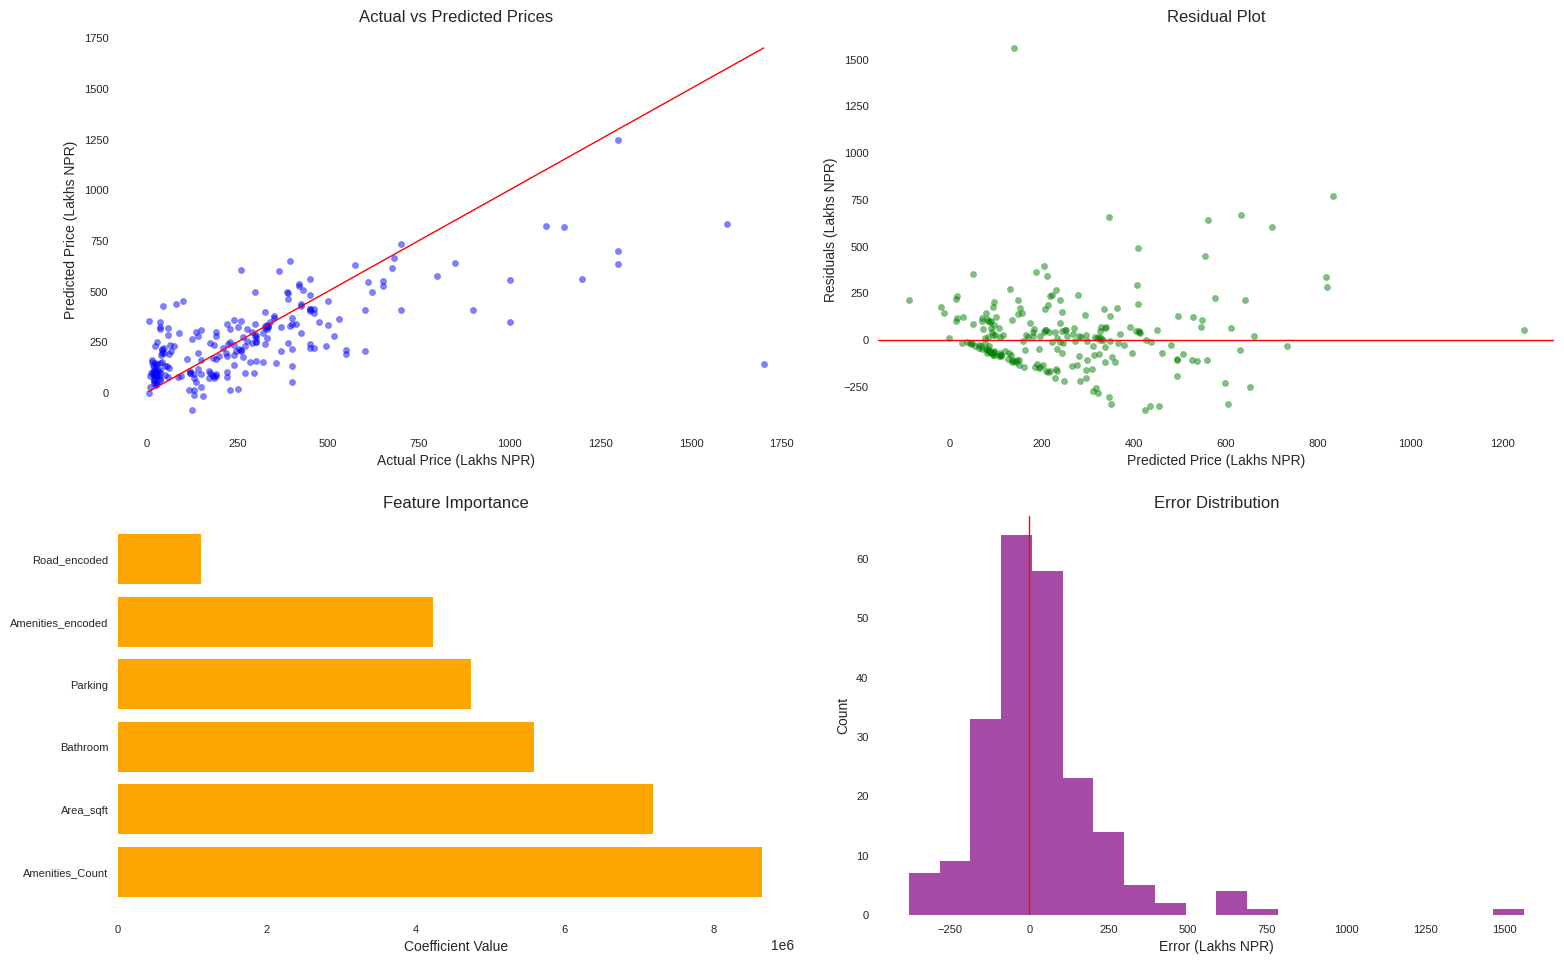

Visualizations completed!


In [78]:
# Creating figure with specific DPI for Colab
fig, axes = plt.subplots(2, 2, figsize=(16, 10), dpi=100)

# Converting to Lakhs for cleaner display
y_test_lakhs = y_test / 100000
y_test_pred_lakhs = y_test_pred / 100000
residuals_lakhs = (y_test - y_test_pred) / 100000

# 1. Actual vs Predicted (Test set)
axes[0, 0].scatter(y_test_lakhs, y_test_pred_lakhs, alpha=0.5, s=20, color='blue')
axes[0, 0].plot([y_test_lakhs.min(), y_test_lakhs.max()],
                [y_test_lakhs.min(), y_test_lakhs.max()], 'r-', linewidth=1)
axes[0, 0].set_xlabel('Actual Price (Lakhs NPR)', fontsize=10)
axes[0, 0].set_ylabel('Predicted Price (Lakhs NPR)', fontsize=10)
axes[0, 0].set_title('Actual vs Predicted Prices', fontsize=12)

# 2. Residuals plot
axes[0, 1].scatter(y_test_pred_lakhs, residuals_lakhs, alpha=0.5, s=20, color='green')
axes[0, 1].axhline(y=0, color='red', linestyle='-', linewidth=1)
axes[0, 1].set_xlabel('Predicted Price (Lakhs NPR)', fontsize=10)
axes[0, 1].set_ylabel('Residuals (Lakhs NPR)', fontsize=10)
axes[0, 1].set_title('Residual Plot', fontsize=12)

# 3. Feature importance plot
top_features = feature_importance.head(6)
axes[1, 0].barh(range(len(top_features)), top_features['Abs_Coefficient'], color='orange')
axes[1, 0].set_yticks(range(len(top_features)))
axes[1, 0].set_yticklabels(top_features['Feature'], fontsize=9)
axes[1, 0].set_xlabel('Coefficient Value', fontsize=10)
axes[1, 0].set_title('Feature Importance', fontsize=12)

# 4. Predicting error distribution
axes[1, 1].hist(residuals_lakhs, bins=20, alpha=0.7, color='purple', edgecolor='none')
axes[1, 1].axvline(x=0, color='red', linestyle='-', linewidth=1)
axes[1, 1].set_xlabel('Error (Lakhs NPR)', fontsize=10)
axes[1, 1].set_ylabel('Count', fontsize=10)
axes[1, 1].set_title('Error Distribution', fontsize=12)

# Cleaning up plots
for ax in axes.flat:
    ax.tick_params(labelsize=8)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.tight_layout(pad=2.0)
plt.show()

print("Visualizations completed!")

In [79]:
# Making sample predictions
print("=== SAMPLE PREDICTIONS ===")
sample_indices = np.random.choice(X_test.index, 5, replace=False)
for idx in sample_indices:
    actual = y_test.loc[idx] / 100000  # Convert to Lakhs
    predicted = lr_model.predict(scaler.transform(X_test.loc[[idx]]))[0] / 100000
    error = abs(actual - predicted)
    print(f"Property {idx}: Actual: {actual:.1f} Lakhs, Predicted: {predicted:.1f} Lakhs, Error: {error:.1f} Lakhs")

=== SAMPLE PREDICTIONS ===
Property 2198: Actual: 110.0 Lakhs, Predicted: 163.6 Lakhs, Error: 53.6 Lakhs
Property 1107: Actual: 270.0 Lakhs, Predicted: 94.5 Lakhs, Error: 175.5 Lakhs
Property 891: Actual: 250.0 Lakhs, Predicted: 16.5 Lakhs, Error: 233.5 Lakhs
Property 1649: Actual: 125.0 Lakhs, Predicted: -88.6 Lakhs, Error: 213.6 Lakhs
Property 634: Actual: 240.0 Lakhs, Predicted: 358.0 Lakhs, Error: 118.0 Lakhs


In [80]:
def predict_price_lakhs(
    bedroom, bathroom, floors, parking,
    area_sqft, road_width_ft, amenities_count, neighborhood_slider_value=1
):
    """
    Predict house price using full feature set, matching training names exactly.

    IMPORTANT: neighborhood_slider_value should be 1-100+ (user-friendly)
    This function automatically converts it to the actual model value (millions range)
    """

    # Converting slider value (1-100+) to actual encoded value
    actual_neighborhood_encoded = neighborhood_slider_mapping.get(neighborhood_slider_value, 0)

    input_dict = {feature: 0 for feature in X.columns}


    if 'Bedroom' in input_dict:
        input_dict['Bedroom'] = bedroom
    if 'Bathroom' in input_dict:
        input_dict['Bathroom'] = bathroom
    if 'Floors' in input_dict:
        input_dict['Floors'] = floors
    if 'Parking' in input_dict:
        input_dict['Parking'] = parking
    if 'Area_sqft' in input_dict:
        input_dict['Area_sqft'] = area_sqft
    if 'Road_Width_ft' in input_dict:
        input_dict['Road_Width_ft'] = road_width_ft
    if 'Amenities_Count' in input_dict:
        input_dict['Amenities_Count'] = amenities_count
    if 'Neighborhood_encoded' in input_dict:
        input_dict['Neighborhood_encoded'] = actual_neighborhood_encoded  # Use converted value

    # Converting to DataFrame
    input_df = pd.DataFrame([input_dict])

    # Scaling and predict
    input_scaled = scaler.transform(input_df)
    predicted_price_npr = lr_model.predict(input_scaled)[0]
    return predicted_price_npr / 100000  # in Lakhs

# Testing the function with slider value (user-friendly)
test_price = predict_price_lakhs(3, 2, 2, 1, 1500, 20, 5, neighborhood_slider_value=5)
print(f"Test prediction: ₹{test_price:.2f} Lakhs")
print(f"Used neighborhood: {slider_to_name_mapping.get(5, 'Unknown')}")


Test prediction: ₹152.77 Lakhs
Used neighborhood: Balkhu


In [81]:
# Printing neighborhood reference for slider
print("=== NEIGHBORHOOD REFERENCE FOR SLIDER (Use These Numbers) ===")
print("Slider Value : Neighborhood Name")
print("-" * 40)
for slider_num, neighborhood_name in sorted(slider_to_name_mapping.items()):
    print(f"{slider_num:2d} : {neighborhood_name}")

print(f"\nUse slider values 1-{len(slider_to_name_mapping)} in the widget below")

@interact(
    bedroom=(1, 16, 1),
    bathroom=(1, 10, 1),
    floors=(1, 10, 1),
    parking=(1, 10, 1),
    area_sqft=(100, 9000, 100),
    road_width_ft=(3, 50, 1),
    amenities_count=(0, 30, 1),
    neighborhood_slider_value=(1, len(slider_to_name_mapping), 1)  # Dynamic range based on actual neighborhoods
)
def predict_interactively(bedroom, bathroom, floors, parking, area_sqft, road_width_ft, amenities_count, neighborhood_slider_value=1):
    price = predict_price_lakhs(
        bedroom, bathroom, floors, parking,
        area_sqft, road_width_ft, amenities_count, neighborhood_slider_value
    )

    # Getting neighborhood name for the slider value
    neighborhood_name = slider_to_name_mapping.get(neighborhood_slider_value, "Unknown")
    actual_encoded_value = neighborhood_slider_mapping.get(neighborhood_slider_value, 0)

    print(f"\n Predicted House Price: ₹{price:.2f} Lakhs (₹{price*100000:,.0f} NPR)")
    print(f" Selected Neighborhood: {neighborhood_name}")
    print(f" Slider Value: {neighborhood_slider_value} → Model Value: {actual_encoded_value:,.0f}")


=== NEIGHBORHOOD REFERENCE FOR SLIDER (Use These Numbers) ===
Slider Value : Neighborhood Name
----------------------------------------
 1 : Anamnagar
 2 : Bafal
 3 : Balaju
 4 : Balambu
 5 : Balkhu
 6 : Baluwatar
 7 : Banasthali
 8 : Baneshwor
 9 : Baniyatar
10 : Basantapur
11 : Basbari
12 : Basundhara
13 : Battisputali
14 : Bhangal
15 : Bishal Nagar
16 : Boudha
17 : Buddhanagar
18 : Budhanilkantha
19 : Chabahil
20 : Chamati
21 : Chandol
22 : Chandragiri
23 : Chapali
24 : Chhauni
25 : Chovar
26 : Chundevi
27 : Dallu
28 : Dhapasi
29 : Dharmasthali
30 : Dhumbarahi
31 : Dhungedhara
32 : Dillibazar
33 : Durbar Marg
34 : Ekatabasti
35 : Gairidhara
36 : Gairigaun
37 : Gaurighat
38 : Gaushala
39 : Ghattekulo
40 : Gokarneshwor
41 : Goldhunga
42 : Golfutar
43 : Gongabu
44 : Gothatar
45 : Grande Villa
46 : Guheshwori
47 : Gurujudhara
48 : Hadigaun
49 : Hattigauda
50 : Hattisar
51 : Jamal
52 : Joranku
53 : Jorpati
54 : Kadaghari
55 : Kageshwari-Manohara
56 : Kalanki
57 : Kalikasthan
58 : Kalimat

interactive(children=(IntSlider(value=8, description='bedroom', max=16, min=1), IntSlider(value=5, description…